# Nichtlineare Ausgleichsrechnung

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular, qr
import sympy as sp

## Modell

Daten

In [2]:
data = np.array([
    [0.1, 0.3, 0.7, 1.2, 1.6, 2.2, 2.7, 3.1, 3.5, 3.9],
    [0.558, 0.569, 0.176, -0.207, -0.133, 0.132, 0.055, -0.090, -0.069, 0.027]
]).T

Das Modell ist gegeben durch eine gedämpfte Schwingung

\begin{equation}y(t;x_1,x_2,x_3,x_4) = x_1\,e^{-x_2 t}\sin(x_3 t+x_4).\end{equation}

Für die Daten sollen Amplitude, Dämpfung, Frequenz und Phase bestimmt werden.

In [3]:
# Modellfunktion (direkt Numpy)
def y(t,x):
    a, tau, omega, phi = x
    return a*np.exp(-tau*t)*np.sin(omega*t+phi)

# Implementierung des Gradienten (direkt Numpy)
def dy(t,x):
    a, tau, omega, phi = x
    return np.array([np.exp(-tau*t)*np.sin(omega*t+phi),
                     -t*a*np.exp(-tau*t)*np.sin(omega*t+phi),
                     t*a*np.exp(-tau*t)*np.cos(omega*t+phi),
                     a*np.exp(-tau*t)*np.cos(omega*t+phi)]).T

# Implementierung der Hess'schen Matrix (direkt Numpy)
def Hy(t,x):
    a, tau, omega, phi = x
    return np.array([[[0,-ti*np.exp(-tau*ti)*np.sin(omega*ti+phi),ti*np.exp(-tau*ti)*np.cos(omega*ti+phi),np.exp(-tau*ti)*np.cos(omega*ti+phi)],
                     [-ti*np.exp(-tau*ti)*np.sin(omega*ti+phi),ti**2*a*np.exp(-tau*ti)*np.sin(omega*ti+phi),-ti**2*a*np.exp(-tau*ti)*np.cos(omega*ti+phi),-ti*a*np.exp(-tau*ti)*np.cos(omega*ti+phi)],
                     [ti*np.exp(-tau*ti)*np.cos(omega*ti+phi),-ti**2*a*np.exp(-tau*ti)*np.cos(omega*ti+phi),-ti**2*a*np.exp(-tau*ti)*np.sin(omega*ti+phi),-ti*a*np.exp(-tau*ti)*np.sin(omega*ti+phi)],
                     [np.exp(-tau*ti)*np.cos(omega*ti+phi),-ti*a*np.exp(-tau*ti)*np.cos(omega*ti+phi),-ti*a*np.exp(-tau*ti)*np.sin(omega*ti+phi),-a*np.exp(-tau*ti)*np.sin(omega*ti+phi)]] for ti in t])

In [4]:
# Fehlerquadratsumme
def phi(data, x):
    t,yi = data.T
    Fi = y(t,x)-yi
    return 0.5*Fi.dot(Fi)

# Gradient Fehlerquadratsumme
def dphi(data, x):
    t,yi = data.T
    Fi = y(t,x)-yi
    dFi = dy(t,x)
    return dFi.T@Fi

# Hess'sche Matrix Fehlerquadratsumme
def Hphi(data, x, reduced = True):
    t,yi = data.T
    Fi = y(t,x)-yi
    dFi = dy(t,x)
    Hyi = Hy(t,x)
    s1 = dFi.T@dFi
    s2 = 0 if reduced else np.sum([Fi[k]*Hyi[k] for k in range(yi.shape[0])],axis=0)
    return s1 + s2

## Gauss-Newton und Newton Verfahren

In [5]:
# selber im Praktikum implementieren
from NichtlineareAusgleichsrechnungLib import GaussNewton

Eine minimal Stelle der Fehlerquadratsumme erfüllt die die Gleichung $\nabla\phi(x) = 0$. Wir berechnen mit Hilfe des Newton-Verfahren die Nullstelle. Dazu benötigen wir die oben definierte Hess'sche Matrix:

In [6]:
def Newton(data, x0, phi, dphi, Hphi,
           maxIter=100, maxDamp=20, tol=1e-12):
    # Daten
    t, yi = data.T
    # Initialisierung des Parameter Vektors
    x = np.array(x0)
    # Liste fuer die Visualisierung der Konvergenz
    res = []
    for k in range(maxIter):
        if k<3:
            # (reduzierte) Hess'sche Matrix von phi
            A = Hphi(data,x,reduced=True)
        else:
            # Hess'sche Matrix von phi
            A = Hphi(data,x,reduced=False)
        # Gradient von phi
        b = dphi(data,x)
        # Newton-Schritt
        q,r = qr(A,mode='economic')
        s = solve_triangular(r,q.T@b)
        # Daempfung, phi muss kleiner werden
        alpha = 1.
        for j in range(maxDamp):
            xn = x-alpha*s
            if phi(data,xn) < phi(data,x):
                break
            else:
                alpha /= 2
        x -= alpha*s
        res.append(np.linalg.norm(dphi(data,x)))
        print(k, phi(data,x), res[-1], alpha)
        if np.linalg.norm(s) < tol:
            break
    return x,res

In [7]:
x0 = np.array([1, 1, 3, 1],dtype=float)
xN,resN = Newton(data,x0,phi,dphi,Hphi)

0 0.006673535239173661 0.07066924178449757 1.0
1 0.004033519639008082 0.007667311379775573 1.0
2 0.0039697638126295785 0.0013838504393927122 1.0
3 0.003963649748752298 1.6485434862469543e-05 1.0
4 0.003963649054560297 3.4785202919888354e-09 1.0
5 0.003963649054560273 1.5516887710921733e-16 1.0
6 0.003963649054560272 1.9299985848078835e-16 0.25


Im Vergleich dazu betrachten wir die Lösung bzw. das Konvergenz-Verhalten des Gauss-Newton Algorithmus gegeben aus der Vorlesung. Die eigene Implementierung des Gauss-Newton Algorithmus ist Inhalt des Praktikum.

In [8]:
xGN,resGN = GaussNewton(data,x0,y,dy)

0 0.006673535239173671 0.07066924178449756
1 0.0040335196390080845 0.007667311379775534
2 0.003969763812629577 0.001383850439392612
3 0.003964376876659761 0.00043189264339680336
4 0.003963737754840471 0.00015315297340659568
5 0.003963659789483246 5.271531799257331e-05
6 0.003963650357168144 1.8446065026028378e-05
7 0.003963649212505831 6.408222596850327e-06
8 0.003963649073718184 2.2344040945342482e-06
9 0.003963649056883814 7.776815847694655e-07
10 0.003963649054842095 2.709242325054453e-07
11 0.003963649054594453 9.433741891124994e-08
12 0.0039636490545644125 3.2857208580372187e-08
13 0.003963649054560771 1.14424494661288e-08
14 0.00396364905456033 3.985091873460136e-09
15 0.0039636490545602795 1.3878456870227513e-09
16 0.003963649054560275 4.833400946087831e-10
17 0.003963649054560274 1.6832934015642728e-10
18 0.003963649054560274 5.86231170496666e-11
19 0.003963649054560272 2.0416286679951663e-11
20 0.003963649054560267 7.110299683392491e-12
21 0.0039636490545602735 2.4762243131069

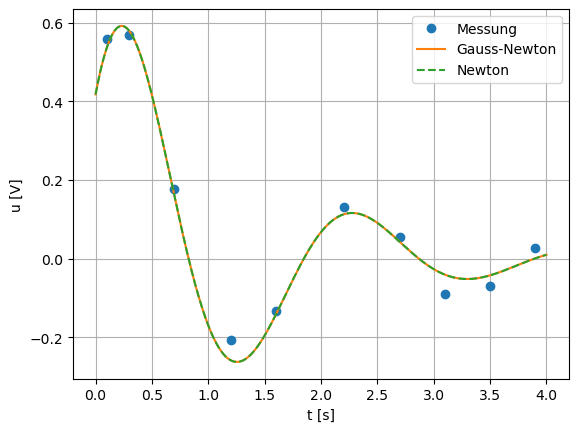

In [9]:
tp = np.linspace(0,4,400)
plt.plot(*data.T,'o',label='Messung')
plt.plot(tp,y(tp,xGN), label='Gauss-Newton')
plt.plot(tp,y(tp,xN),'--', label='Newton')
plt.legend()
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('u [V]')
#plt.savefig('NonlinRegressBeispielSolution.pdf')
plt.show()

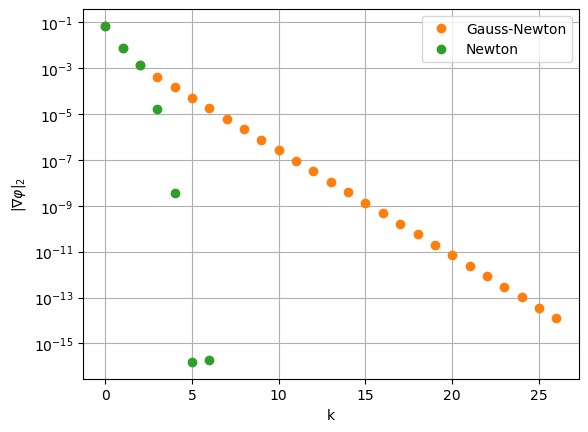

In [10]:
plt.semilogy(resGN, 'o', c='tab:orange', label='Gauss-Newton')
plt.semilogy(resN,'o', c='tab:green', label='Newton')
plt.legend()
plt.grid()
plt.xlabel('k')
plt.ylabel(r'$\|\nabla \varphi\|_2$')
#plt.savefig('NonlinRegressBeispielKonvergenz.pdf')
plt.show()

## Levenberg Marquardt

In [11]:
from NichtlineareAusgleichsrechnungLib import LevenbergMarquardt

Das Levenberg-Marquardt Verfahren benutzt zwei Ansätze kombiniert. Zum einen wird eine Regularisierung eingeführt und zum andern eine Trust Region Strategie benutzt (vgl. Skript).

In [12]:
xLM,resLM = LevenbergMarquardt(data,x0,y,dy)

0 USED 0.9806930724984753 0.02522309181409673 0.17285585253073918 0.5
1 USED 0.966743198838584 0.008653026324286795 0.038992518483582254 0.25
2 USED 1.0690298186175362 0.004742831395895376 0.014525297100761905 0.125
3 USED 0.9689610507864899 0.003998477441547046 0.004238121160033926 0.0625
4 USED 1.0587686404655003 0.003965149563202187 0.0006920225278408606 0.03125
5 USED 0.9703069931253844 0.003963737808783977 0.00015005328879465278 0.015625
6 USED 0.8231176366477855 0.003963656349909945 4.610316702023821e-05 0.0078125
7 USED 0.7175674870316264 0.003963649816848028 1.3789973649376374e-05 0.0078125
8 USED 0.6731120403436198 0.003963649142260981 4.85950466939716e-06 0.0078125
9 USED 0.6586292353941906 0.0039636490649735175 1.6356205271364175e-06 0.0078125
10 USED 0.6542237205365327 0.003963649055808716 5.732618016672834e-07 0.0078125
11 USED 0.6529533939512067 0.003963649054710364 1.9743631222088448e-07 0.0078125
12 USED 0.6529533939512067 0.0039636490545783346 6.873235821832852e-08 0.0

In [13]:
x1 = np.array([3, 6, 6, 3],dtype=float)
xLM2,resLM2 = LevenbergMarquardt(data,x1,y,dy)

0 USED 1.0688949493208173 0.6046111148862408 0.8273909422867344 0.5
1 USED 0.9737610307872686 0.3747211303868591 0.2720130063224477 0.25
2 USED 0.7128631919430277 0.2563666206008889 0.13957511146131057 0.25
3 USED 0.4900585971435755 0.21770136422014721 0.1310297280092487 0.25
4 USED 1.0275298771905637 0.16497114046775874 0.08110172361955954 0.125
5 NOT  -4.249547548328965 0.16497114046775874 0.08110172361955954 0.25
6 USED 0.8725764875044045 0.13251205948189726 0.0991085112949658 0.125
7 USED 0.5247141798763945 0.10394987595977338 0.38433845837900554 0.125
8 USED 0.9987748295204908 0.06328659906475677 0.06187034873177772 0.0625
9 USED 0.9914348337268244 0.05541433147594083 0.037718410811648326 0.03125
10 USED 0.5397020835316607 0.05116622558523228 0.04707102905735394 0.03125
11 USED 0.4610701111309999 0.04963346243695535 0.047078692938088015 0.03125
12 USED 0.9190916385727865 0.046591895012284404 0.07354592948771659 0.015625
13 NOT  -17931912.43198623 0.046591895012284404 0.07354592948

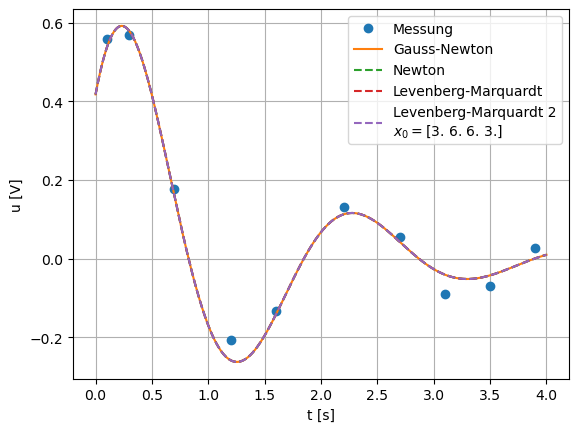

In [14]:
tp = np.linspace(0,4,400)
plt.plot(*data.T,'o',label='Messung')
plt.plot(tp,y(tp,xGN), label='Gauss-Newton')
plt.plot(tp,y(tp,xN),'--', label='Newton')
plt.plot(tp,y(tp,xLM),'--', label='Levenberg-Marquardt')
plt.plot(tp,y(tp,xLM2),'--', label='Levenberg-Marquardt 2\n$x_0=$'+str(x1))
plt.legend()
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('u [V]')
#plt.savefig('NonlinRegressBeispielSolution2.pdf')
plt.show()

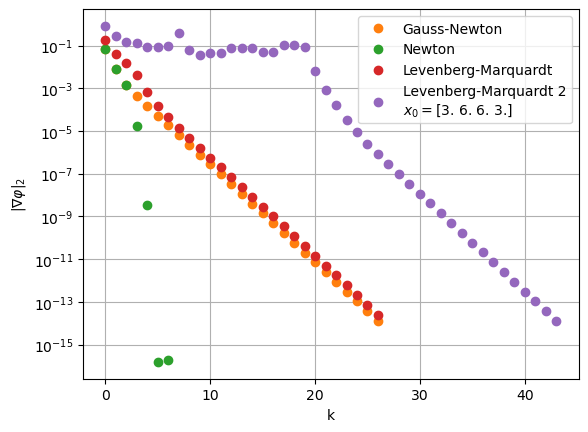

In [15]:
plt.semilogy(resGN, 'o', c='tab:orange', label='Gauss-Newton')
plt.semilogy(resN,'o', c='tab:green', label='Newton')
plt.semilogy(resLM,'o', c='tab:red', label='Levenberg-Marquardt')
plt.semilogy(resLM2,'o', c='tab:purple', label='Levenberg-Marquardt 2\n$x_0=$'+str(x1))
plt.legend()
plt.grid()
plt.xlabel('k')
plt.ylabel(r'$\|\nabla \varphi\|_2$')
#plt.savefig('NonlinRegressBeispielKonvergenz2.pdf')
plt.show()

Aus dem Gauss-Newton Verfahren erhalten wir die Lösung:

In [16]:
xGN

array([0.73535605, 0.79620177, 3.07449929, 0.60418125])

\begin{equation}y(t;x_1,x_2,x_3,x_4) \approx 0.735\,e^{-0.8 t}\sin(3 t + 0.6).\end{equation}